# Procesy Stochastyczne

In [22]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import firwin, lfilter

In [23]:
# Set Random seed
np.random.seed(69420)

In [24]:
# Parametry
# Parametr sigma rozkładu Rayleigha
sigma = 1.0
# Częstotliwość próbkowania w Hz
sampling_freq = 10000
# Liczba różnych próbek
sample_sizes = [1000, 5000, 10000, 50000]

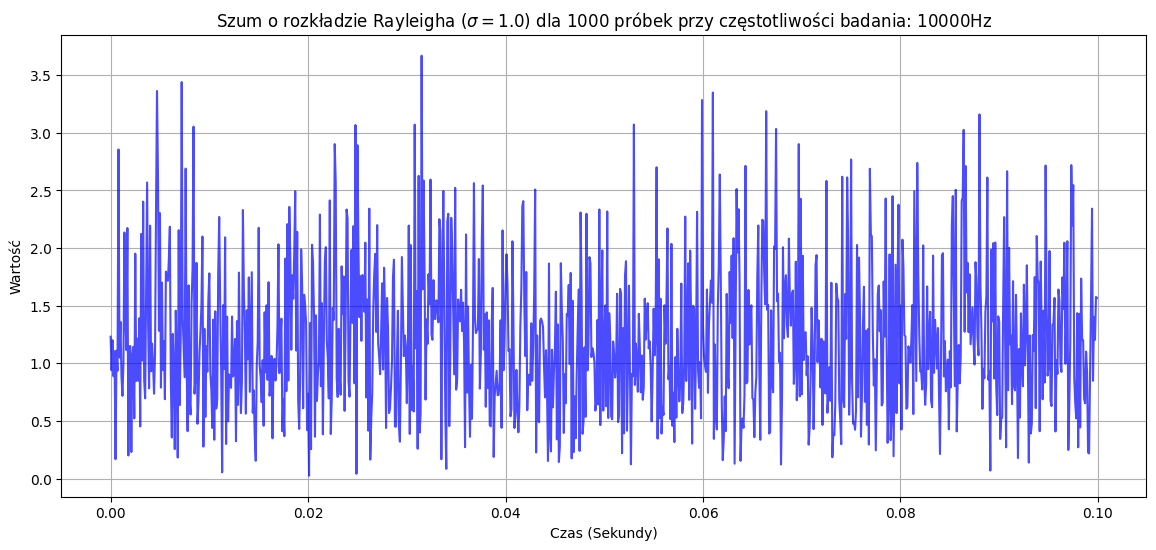

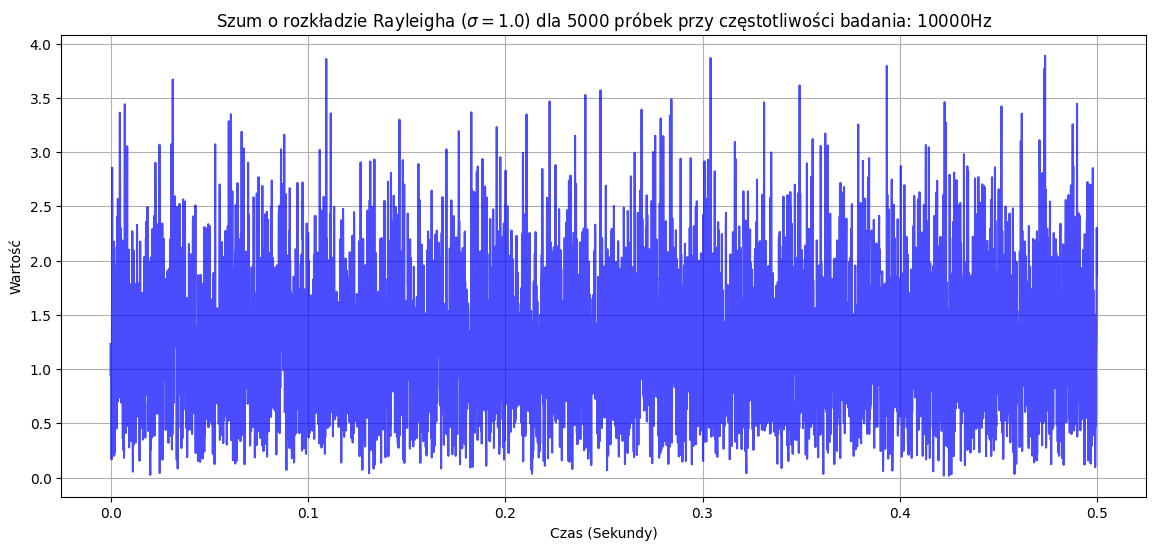

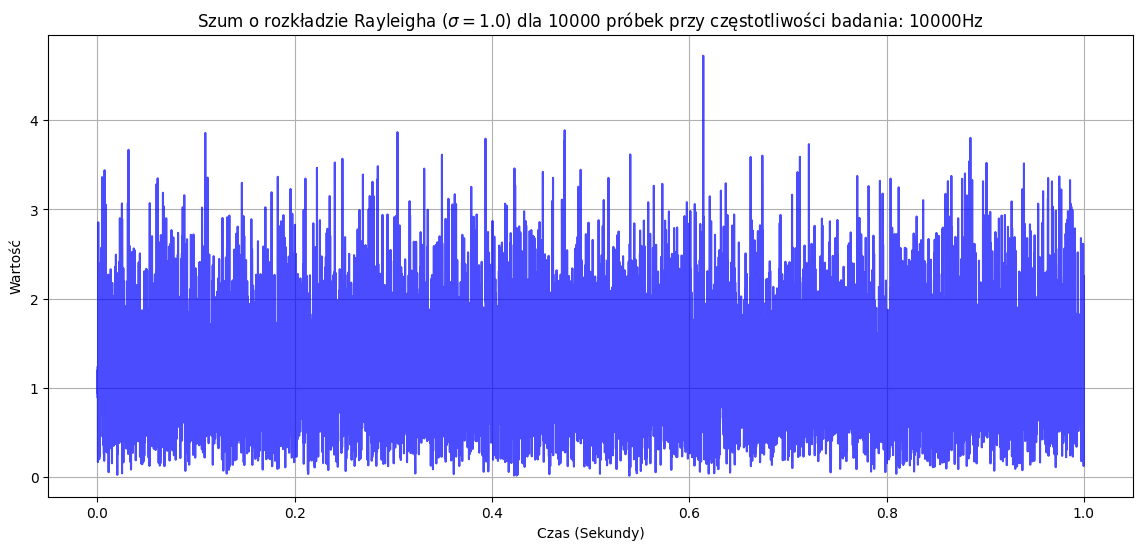

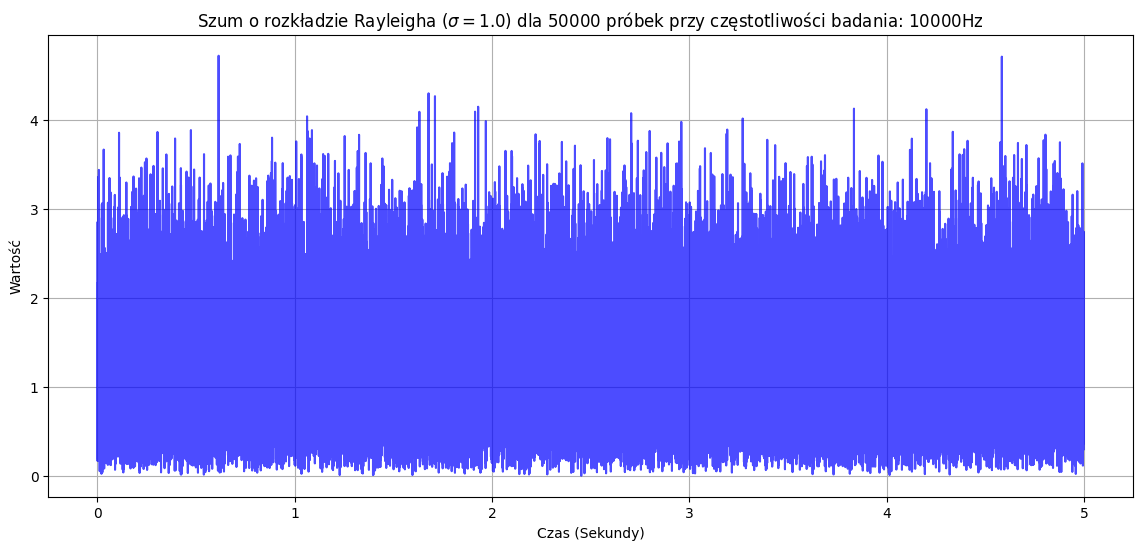

In [25]:
# Obliczenie dodatkowych parametrow
# Liczba wszystkich próbek
num_samples = max(sample_sizes)
# Całkowita długośćtrwania sygnału
duration = num_samples/sampling_freq

# Generowanie szumu
rayleigh_noise = np.random.rayleigh(scale=sigma, size=num_samples)

# Wizualizacja szumu przy różnej ilości próbek
for samples in sample_sizes:
    x_time = np.array([x/num_samples * duration for x in range(samples)])
    plt.figure(figsize=(14, 6))
    plt.plot(x_time, rayleigh_noise[:samples], color="blue", alpha=0.7)
    plt.title(f"Szum o rozkładzie Rayleigha ($\\sigma=1.0$) dla {samples} próbek przy częstotliwości badania: {sampling_freq}Hz")
    plt.xlabel("Czas (Sekundy)", )
    plt.ylabel("Wartość")
    plt.grid(True)
    plt.show()

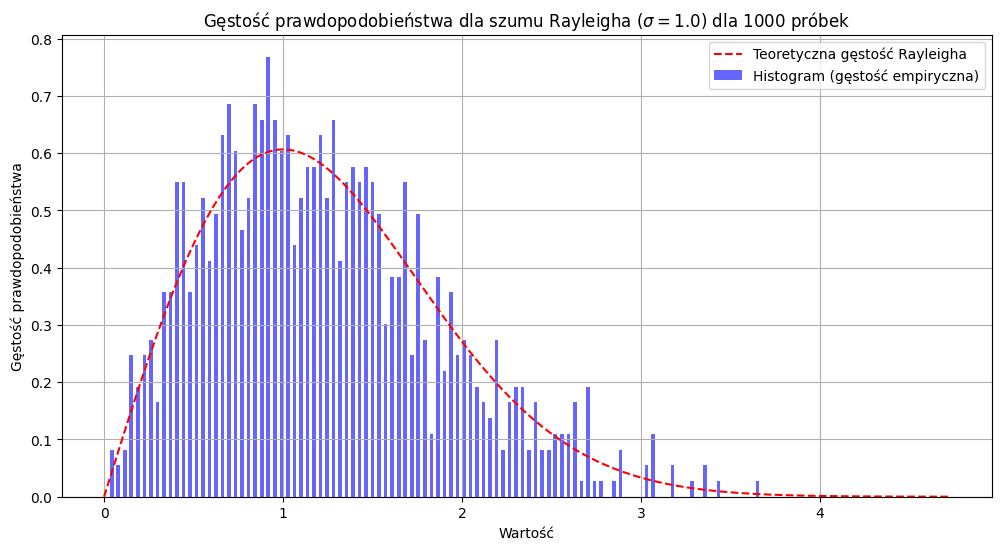

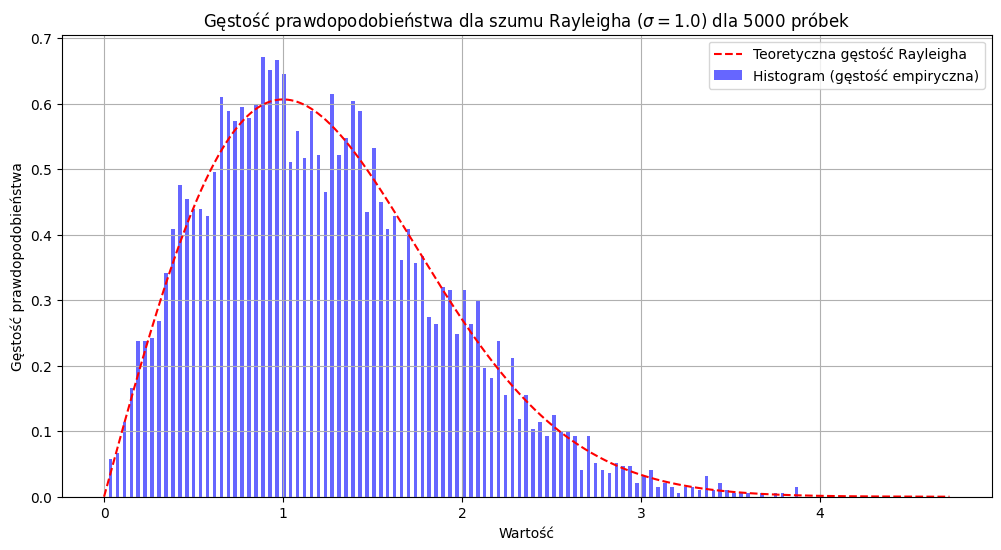

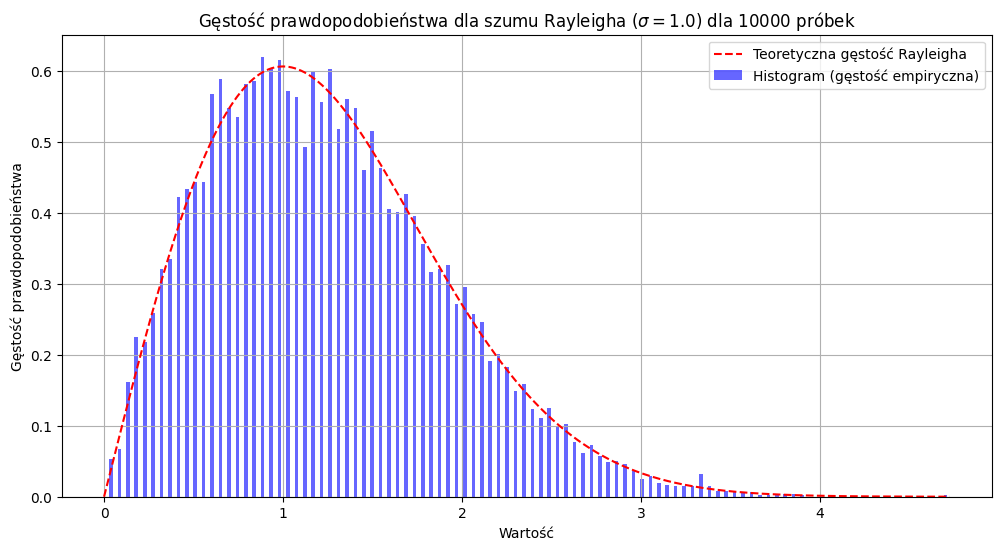

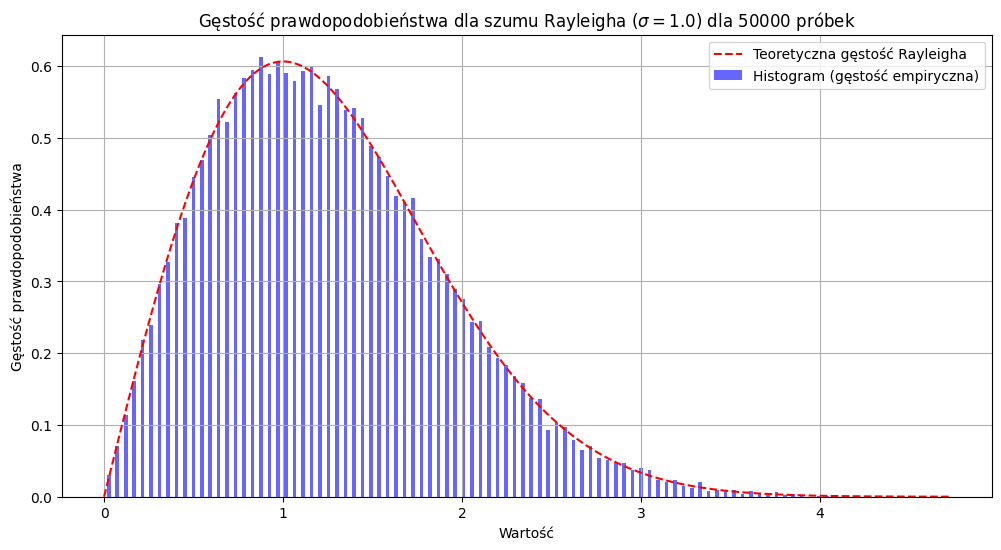

In [26]:
# Wyznaczenie gęstości prawdopodobieństwa (PDF) dla wygenerowanego szumu
pdf_values = []
bins = []
bin_centers = []

x = []
rayleigh_pdf = []

for i in range(len(sample_sizes)):
    pdf_values_d, bins_d = np.histogram(rayleigh_noise[:sample_sizes[i]], bins=100, density=True)
    bin_centers_d = (bins_d[:-1] + bins_d[1:]) / 2  # Środkowe wartości przedziałów
    pdf_values.append(pdf_values_d)
    bins.append(bins_d)
    bin_centers.append(bin_centers_d)

    # Wzorcowa funkcja gęstości prawdopodobieństwa rozkładu Rayleigha dla porównania
    x.append(np.linspace(0, max(rayleigh_noise), sample_sizes[i]))
    rayleigh_pdf.append(stats.rayleigh.pdf(x[i], scale=sigma))

    # Rysowanie histogramu i PDF
    plt.figure(figsize=(12, 6))
    plt.bar(bin_centers[i], pdf_values[i], label="Histogram (gęstość empiryczna)", color="blue", width=0.02, alpha=0.6, )
    plt.plot(x[i], rayleigh_pdf[i], label="Teoretyczna gęstość Rayleigha", color="red", linestyle="--")
    plt.title(f"Gęstość prawdopodobieństwa dla szumu Rayleigha ($\\sigma=1.0$) dla {sample_sizes[i]} próbek")
    plt.xlabel("Wartość")
    plt.ylabel("Gęstość prawdopodobieństwa")
    plt.legend()
    plt.grid(True)
    plt.show()

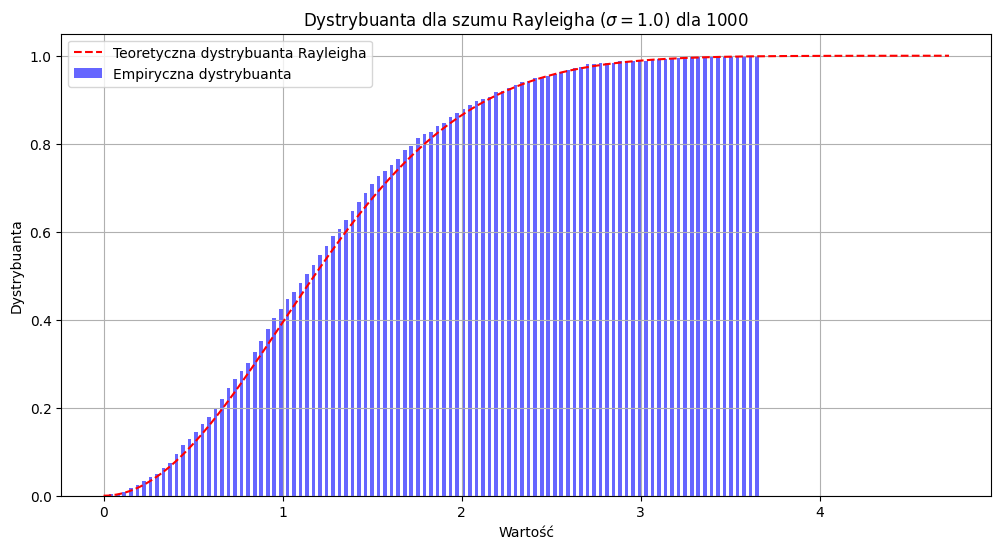

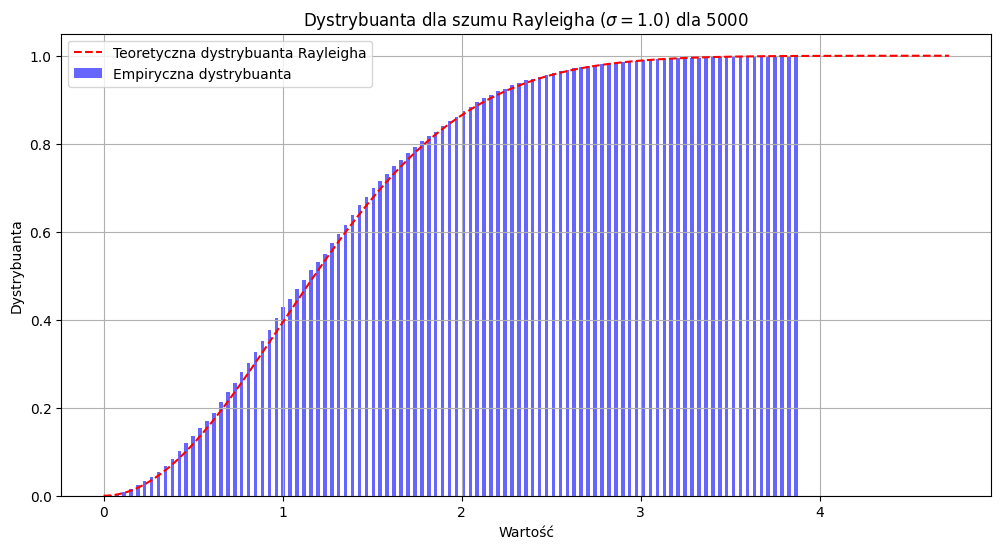

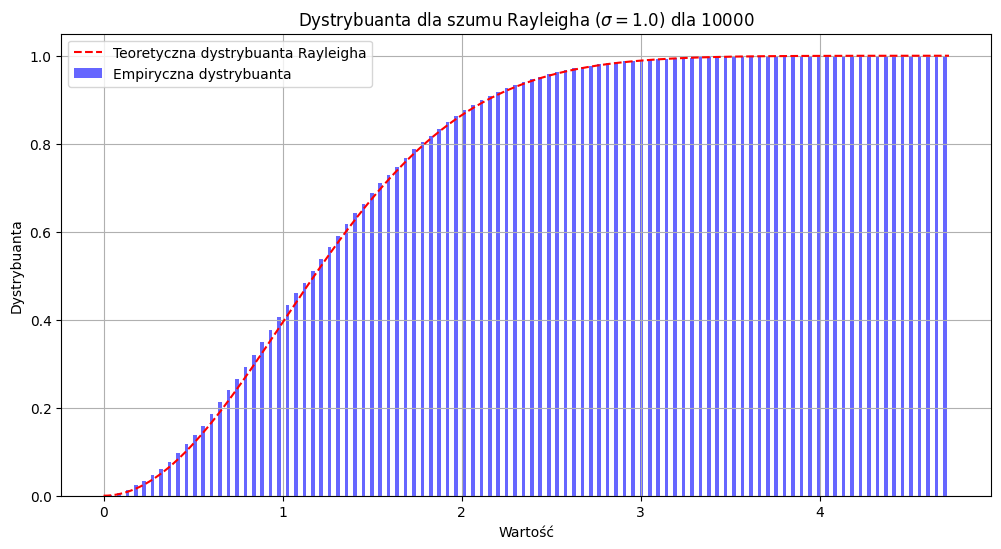

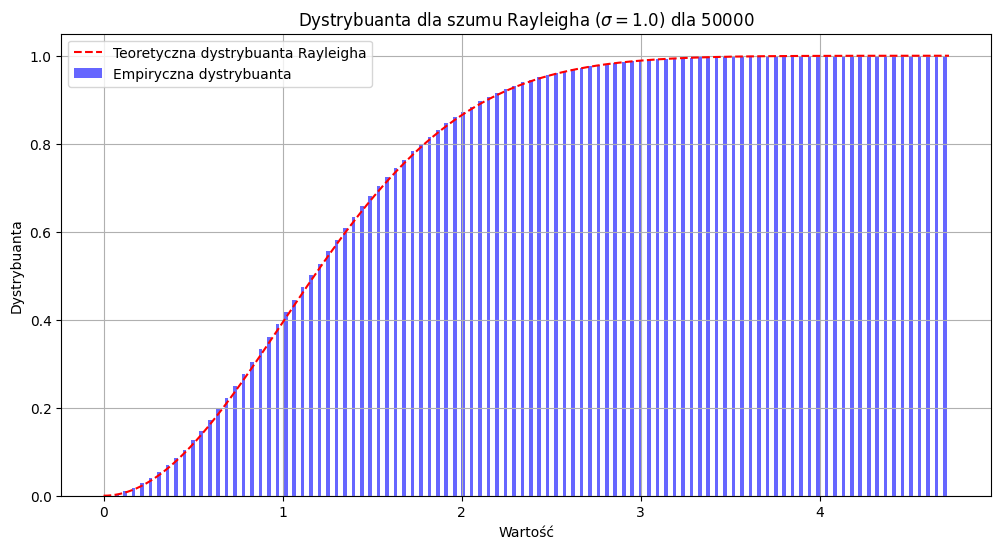

In [27]:
# Obliczanie dystrybuanty (CDF) dla rozkładu Rayleigha na podstawie wygenerowanego szumu
rayleigh_cdf_empirical = []

for i in range(len(sample_sizes)):
    rayleigh_cdf_empirical.append(np.cumsum(pdf_values[i] * np.diff(bins[i])))  # Numeryczna aproksymacja CDF z histogramu

    # Teoretyczna dystrybuanta rozkładu Rayleigha
    rayleigh_cdf_theoretical = stats.rayleigh.cdf(x[i], scale=sigma)

    # Rysowanie dystrybuanty
    plt.figure(figsize=(12, 6))
    plt.bar(bin_centers[i], rayleigh_cdf_empirical[i], label="Empiryczna dystrybuanta", color="blue", width=0.02, alpha=0.6)
    plt.plot(x[i], rayleigh_cdf_theoretical, label="Teoretyczna dystrybuanta Rayleigha", color="red", linestyle="--")
    plt.title(f"Dystrybuanta dla szumu Rayleigha ($\\sigma=1.0$) dla {sample_sizes[i]}")
    plt.xlabel("Wartość")
    plt.ylabel("Dystrybuanta")
    plt.legend()
    plt.grid(True)
    plt.show()

In [28]:
# Obliczenie Wartości Oczekiwanej, Wariancji
# Tabele do obliczeń statystycznych
statistic_tables: list[pd.DataFrame] = []
# Tabela Wyników
summary_table = pd.DataFrame(sample_sizes, columns=['Sample Size'])
summary_table.set_index('Sample Size', inplace = True)
summary_table['Mean/Expected Value'] = 0.0
summary_table['Wariant'] = 0.0
summary_table['Standard Deviation'] = 0.0

# Obliczenie parametrów
for sample_size in sample_sizes:
    table = pd.DataFrame(rayleigh_noise[:sample_size], columns = ['x'])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    summary_table.at[sample_size, 'Mean/Expected Value'] = rayleigh_noise[:sample_size].mean()

    table['x - xsr'] = table['x'] - summary_table.at[sample_size, 'Mean/Expected Value']
    table['(x - xsr)^2'] = table['x - xsr']**2

    summary_table.at[sample_size, 'Wariant'] = (table['(x - xsr)^2'].sum())/(sample_size-1)
    
    statistic_tables.append(table)

summary_table['Standard Deviation'] = summary_table['Wariant']**(1/2)

# Podsumowanie
summary_table

,Mean/Expected Value,Wariant,Standard Deviation
Sample Size,,,
1000,1.224375,0.425301,0.652151
5000,1.236764,0.430649,0.656238
10000,1.244796,0.433730,0.658582
50000,1.255218,0.429222,0.655151


In [29]:
# Obliczenie funkcji kowariancji
# Sumy kowariancji dla poszczególnej liczby próbek:
kowariance_sums = []

# Obliczenie Poszczególnych wyników - Bardzo powolne - niezoptymalizowane.
j_lag = 100
for table in statistic_tables:
    samples = len(table)
    kov_sums_sample = []
    # Stworzenie pustej tabeli
    j_table = pd.DataFrame([[0.0 for i in range(j_lag+1)]for j in range(samples)],
                    columns = [f'f{k}' for k in range(1, j_lag+2)])
    table = table.join(j_table)
    for j in range(j_lag):
        print(f"Table - {samples}: j: {j} / {j_lag}     ", end = '\r')
        samples_n_cov = samples - j
        for i, row in table.iterrows():
            if i >= samples_n_cov:
                break
            table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]
        kov_sums_sample.append(table[f"j{j}"].sum() / samples_n_cov)
    kowariance_sums.append(kov_sums_sample)
    print()         

C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


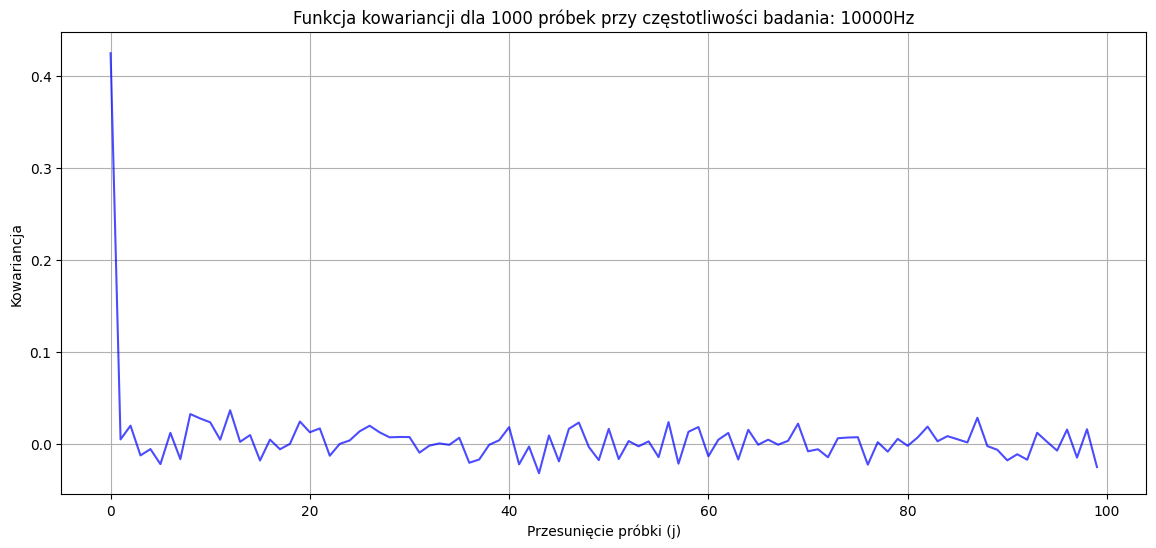

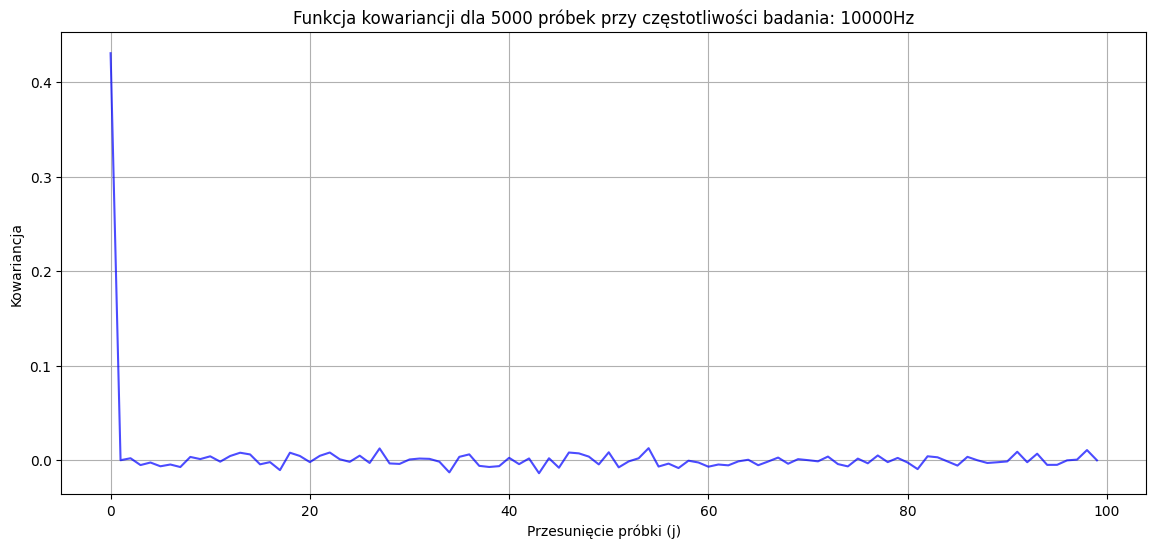

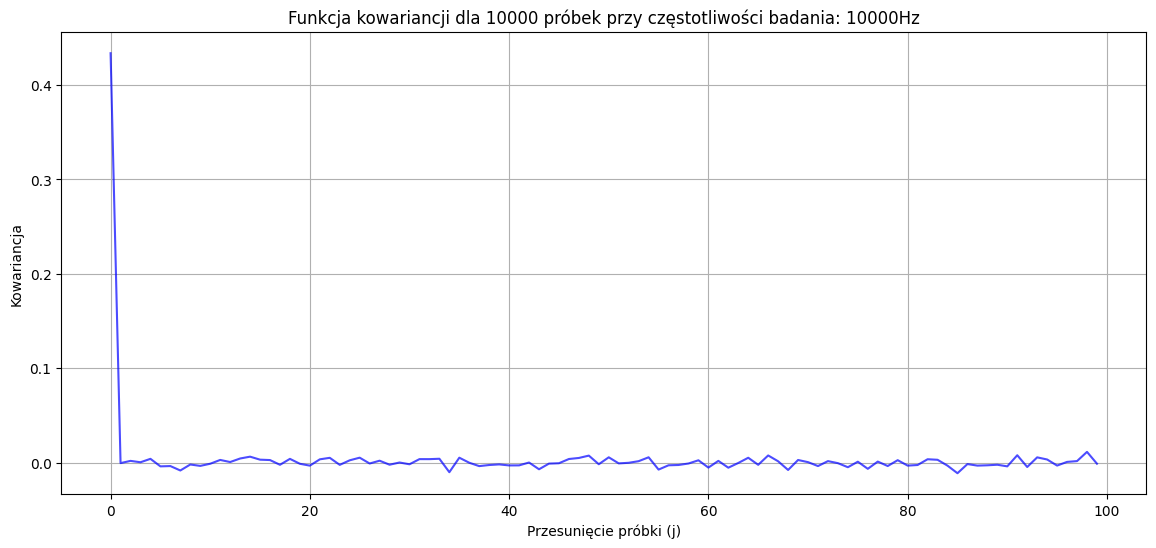

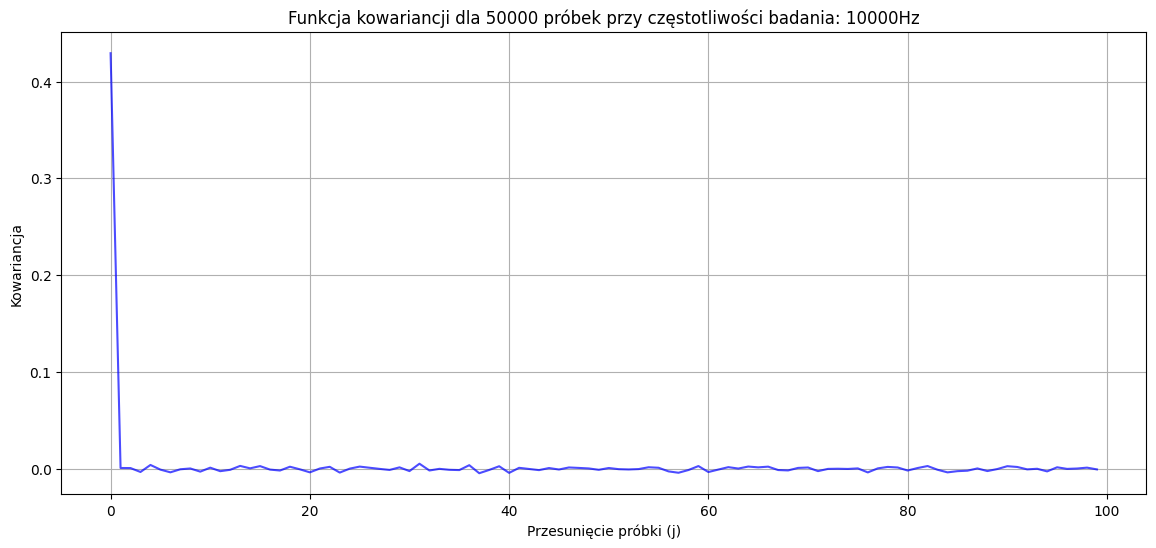

In [30]:
# Rysowanie Funkcji Kowariancji
kowariance_sums_table = pd.DataFrame(kowariance_sums)
kowariance_sums_table = kowariance_sums_table.transpose()

for col in kowariance_sums_table.columns:
    plt.figure(figsize=(14, 6))
    plt.plot(kowariance_sums_table[col], color="blue", alpha=0.7)
    plt.title(f"Funkcja kowariancji dla {sample_sizes[col]} próbek przy częstotliwości badania: {sampling_freq}Hz")
    plt.xlabel("Przesunięcie próbki (j)", )
    plt.ylabel("Kowariancja")
    plt.grid(True)
    plt.show()

In [31]:
# Filtracja Szumu
# Funkcja do projektowania i stosowania filtru FIR
def apply_fir_filter(noise, cutoff_freq, tap_count, fs):
    taps = firwin(tap_count, cutoff_freq, fs=fs, pass_zero="lowpass")
    filtered_signal = lfilter(taps, 1.0, noise)
    return filtered_signal, taps

# Definicje różnych szerokości filtru
filters = [
    {"cutoff_freq": 500, "tap_count": 31},
    {"cutoff_freq": 1000, "tap_count": 31},
    {"cutoff_freq": 2000, "tap_count": 31},
    {"cutoff_freq": 5000, "tap_count": 31}
]

# Filtracja sygnału z różnymi filtrami
filtered_signals = []
for filt in filters:
    filtered_signal, taps = apply_fir_filter(rayleigh_noise, filt["cutoff_freq"], filt["tap_count"], num_samples)
    filtered_signals.append(filtered_signal)

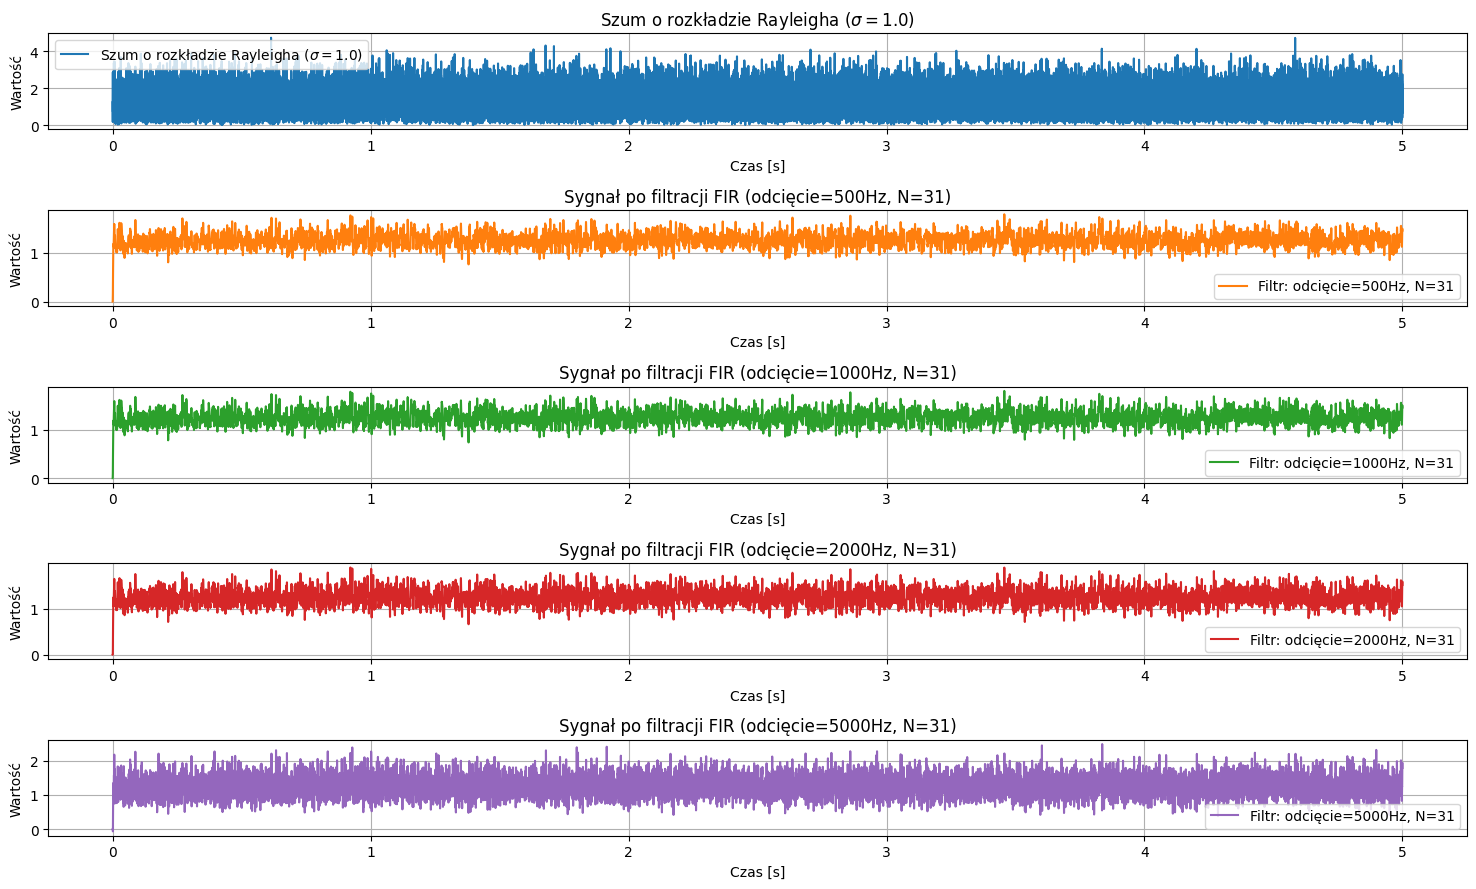

In [48]:
# Wizualizacja
plot_size = 3 * (1 + len(filters))
plt.figure(figsize=(plot_size, 9))

# Biały szum
plt.subplot(len(filters) + 1, 1, 1)
plt.plot(x_time, rayleigh_noise, label="Szum o rozkładzie Rayleigha ($\\sigma=1.0$)")
plt.title("Szum o rozkładzie Rayleigha ($\\sigma=1.0$)")
plt.xlabel("Czas [s]")
plt.ylabel("Wartość")
plt.grid()
plt.legend()

# Sygnały po filtracji z różnymi szerokościami filtru
for i, (filtered_signal) in enumerate(filtered_signals):
    plt.subplot(len(filters) + 1, 1, i + 2)
    plt.plot(x_time, filtered_signal, 
             label=f"Filtr: odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']}",
             color=f"C{i+1}")
    plt.title(f"Sygnał po filtracji FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Czas [s]")
    plt.ylabel("Wartość")
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

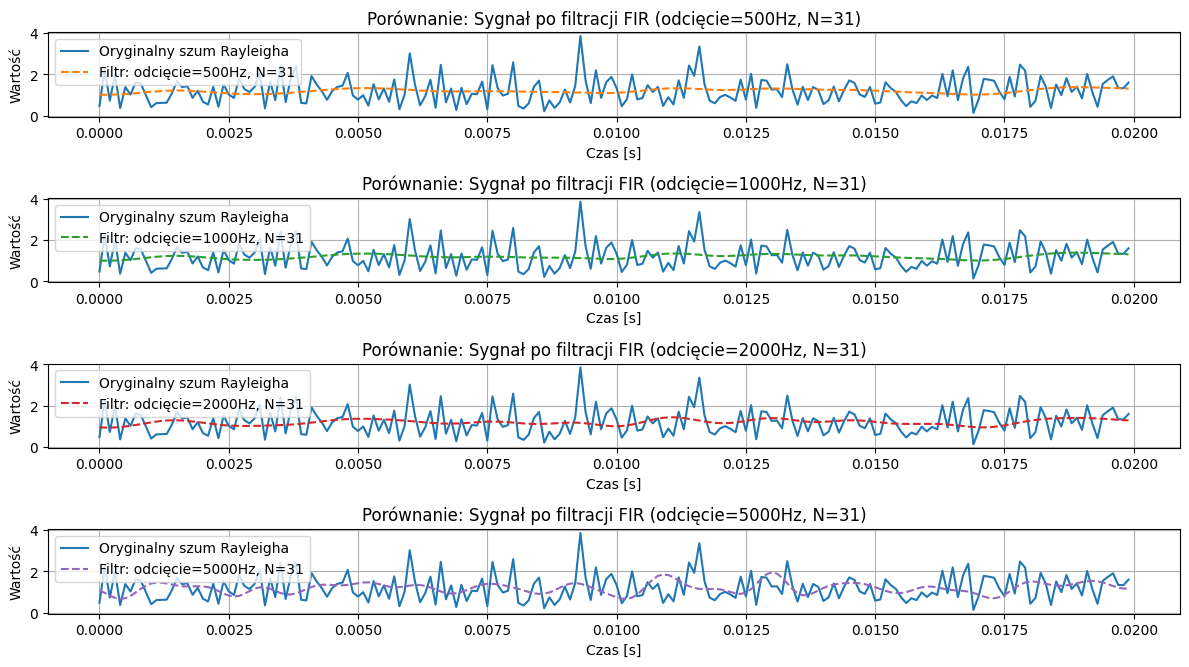

In [50]:
# Wizualizacja - Porownanie z Oryginalem - waski przedział
compare_samples = 200
start_sample = 1000
end_sample = start_sample + compare_samples

plot_size_2 = 5 * (len(filters))
plt.figure(figsize=(12, 8))

for i, (filtered_signal) in enumerate(filtered_signals):
    plt.subplot(len(filters)+1, 1, i + 1)
    plt.plot(x_time[:compare_samples], rayleigh_noise[start_sample:end_sample], label="Oryginalny szum Rayleigha")
    plt.plot(x_time[:compare_samples], 
             filtered_signal[start_sample:end_sample], 
             label=f"Filtr: odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']}", 
             color=f"C{i+1}",  
             linestyle='dashed'
             )
    plt.title(f"Porównanie: Sygnał po filtracji FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Czas [s]")
    plt.ylabel("Wartość")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

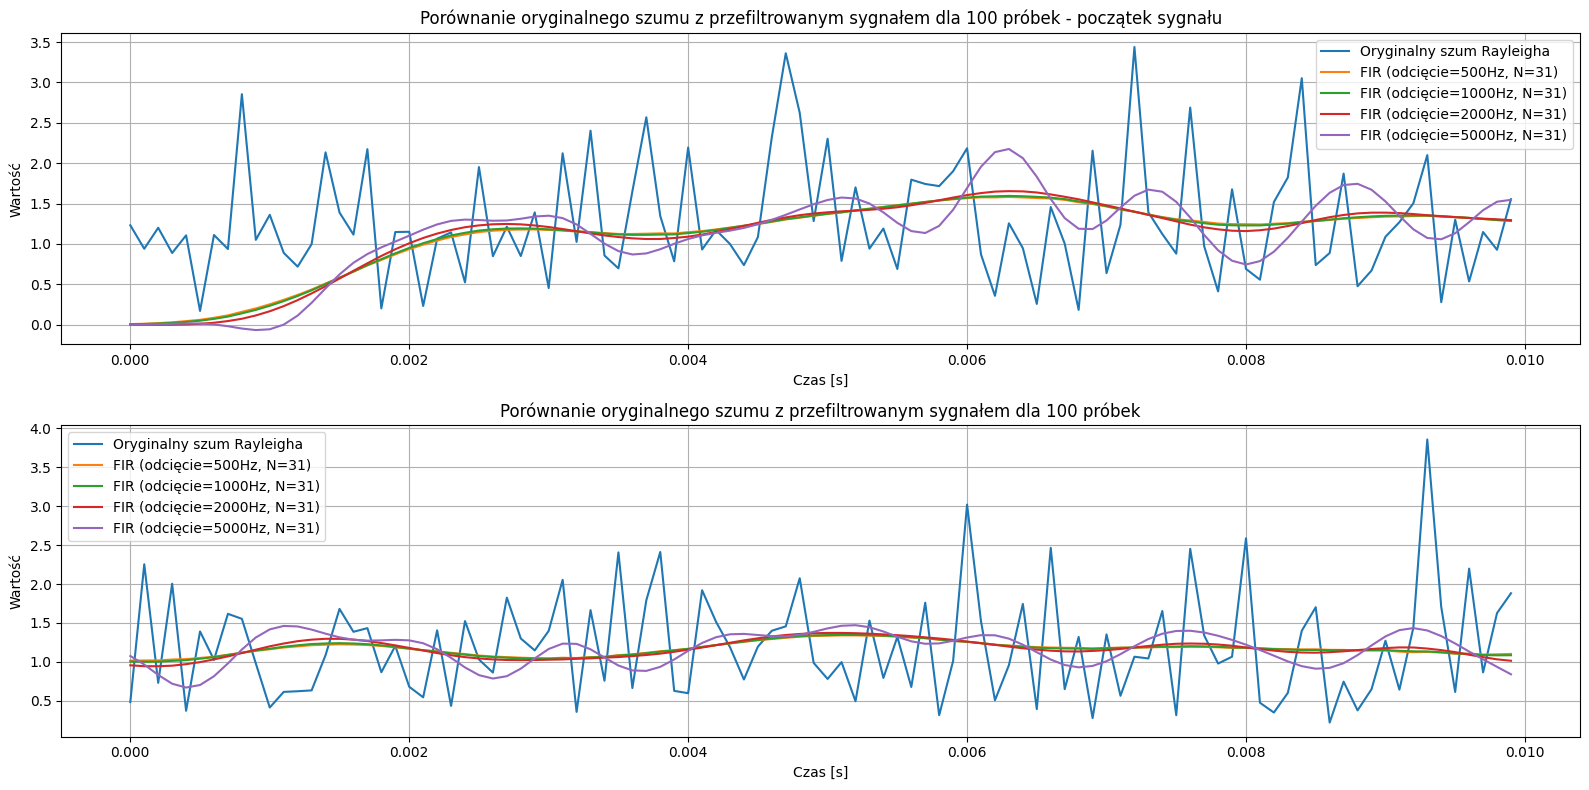

In [34]:
# Wizualizacja - Porownanie z Oryginalem - waski przedział
compare_samples = 100
start_sample = 1000
end_sample = start_sample + compare_samples


plt.figure(figsize=(16, 8))

# Sygnał pierwotny
plt.subplot(2, 1, 1)
plt.plot(x_time[:compare_samples], rayleigh_noise[:compare_samples], label="Oryginalny szum Rayleigha")
for i, filtered_signal in enumerate(filtered_signals):
    plt.plot(x_time[:compare_samples], filtered_signals[i][:compare_samples],
             color=F'C{i+1}',
             label=f"FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
plt.title(f"Porównanie oryginalnego szumu z przefiltrowanym sygnałem dla {compare_samples} próbek - początek sygnału")
plt.xlabel("Czas [s]")
plt.ylabel("Wartość")
plt.legend()
plt.grid()

# Sygnał przefiltrowany
plt.subplot(2, 1, 2)
plt.plot(x_time[:compare_samples], rayleigh_noise[start_sample:end_sample], label="Oryginalny szum Rayleigha")
for i, filtered_signal in enumerate(filtered_signals):
    plt.plot(x_time[:compare_samples], filtered_signals[i][start_sample:end_sample],
             color=F'C{i+1}',
             label=f"FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
plt.title(f"Porównanie oryginalnego szumu z przefiltrowanym sygnałem dla {compare_samples} próbek")
plt.xlabel("Czas [s]")
plt.ylabel("Wartość")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

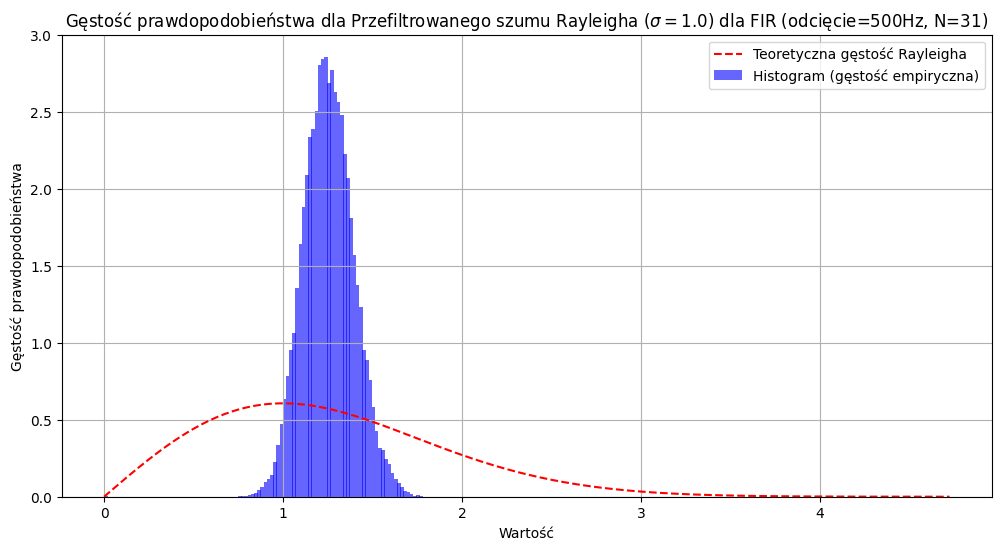

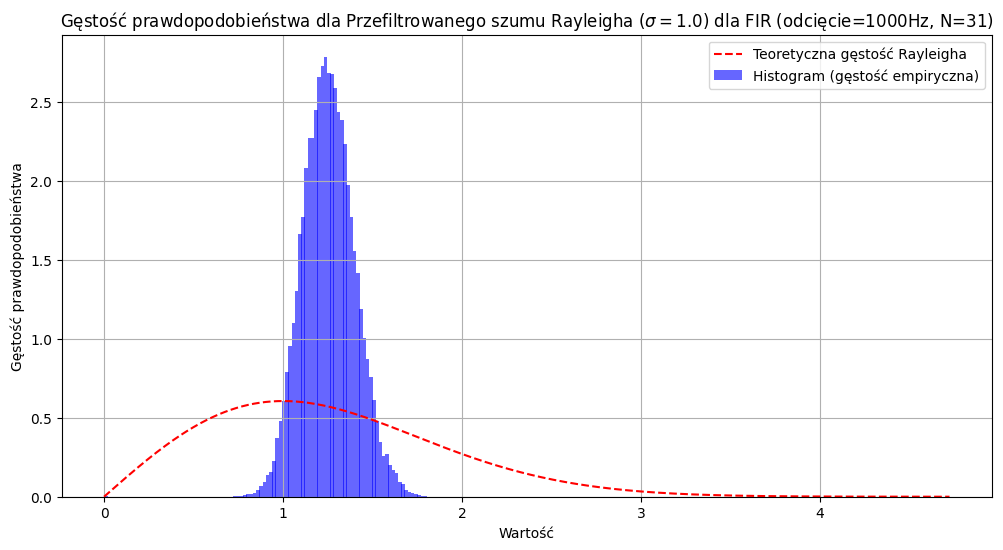

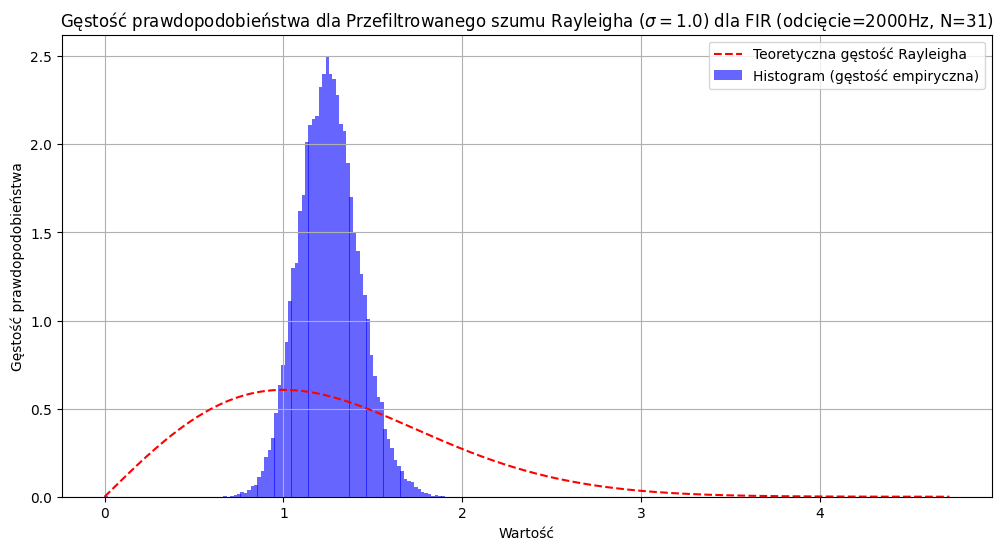

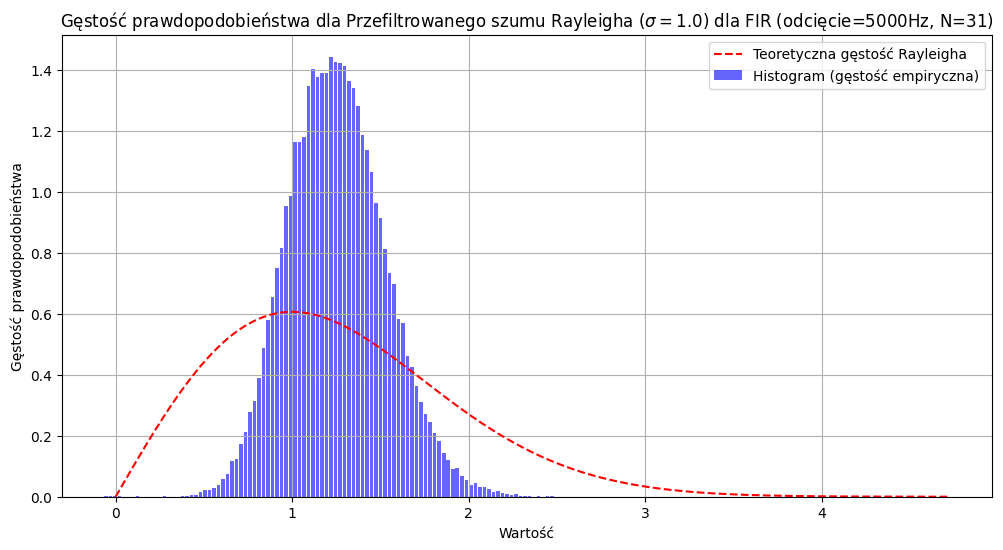

In [35]:
# Wyznaczenie gęstości prawdopodobieństwa (PDF) dla przefiltrowanego szumu
filtered_pdf_values = []
filtered_bins = []
filtered_bin_centers = []

for i, filtered_signal in enumerate(filtered_signals):
    pdf_values_d, bins_d = np.histogram(filtered_signal, bins=100, density=True)
    bin_centers_d = (bins_d[:-1] + bins_d[1:]) / 2  # Środkowe wartości przedziałów
    filtered_pdf_values.append(pdf_values_d)
    filtered_bins.append(bins_d)
    filtered_bin_centers.append(bin_centers_d)

    # Rysowanie histogramu i PDF
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_bin_centers[i], filtered_pdf_values[i], label="Histogram (gęstość empiryczna)", color="blue", width=0.02, alpha=0.6, )
    plt.plot(x[-1], rayleigh_pdf[-1], label="Teoretyczna gęstość Rayleigha", color="red", linestyle="--")
    plt.title(f"Gęstość prawdopodobieństwa dla Przefiltrowanego szumu Rayleigha ($\\sigma=1.0$) dla FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Wartość")
    plt.ylabel("Gęstość prawdopodobieństwa")
    plt.legend()
    plt.grid(True)
    plt.show()

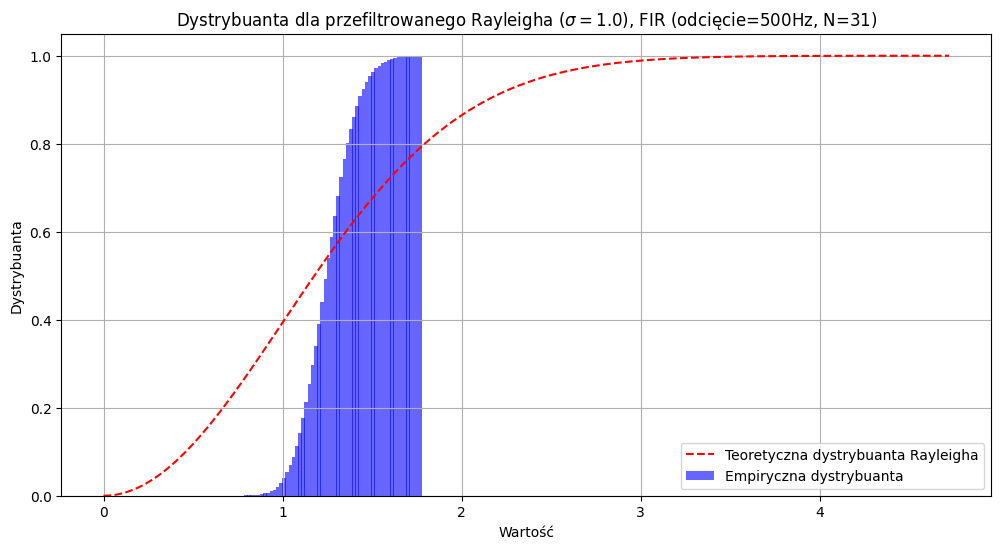

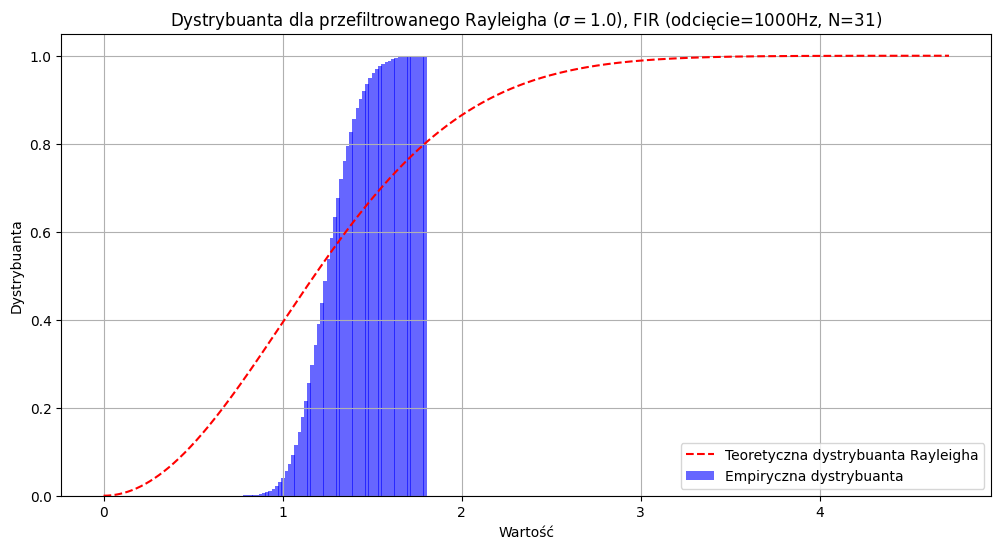

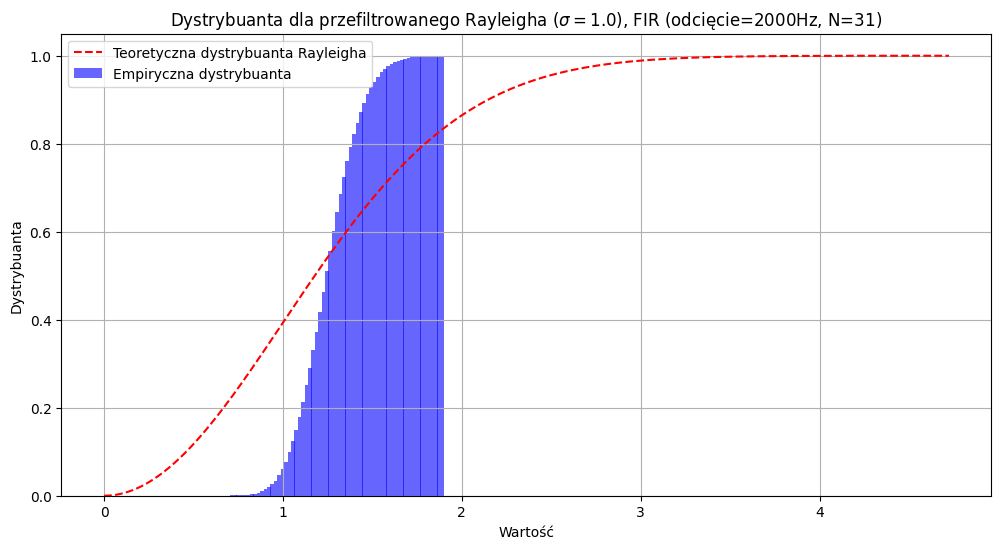

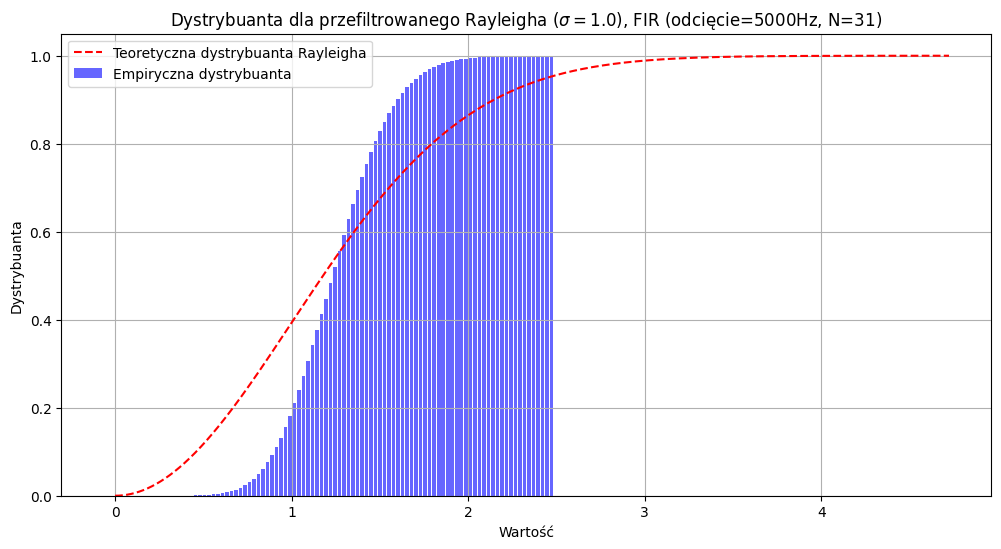

In [36]:
# Obliczanie dystrybuanty (CDF) dla rozkładu Rayleigha na podstawie wygenerowanego szumu
filtered_rayleigh_cdf_empirical = []

for i, filtered_signal in enumerate(filtered_signals):
    filtered_rayleigh_cdf_empirical.append(np.cumsum(filtered_pdf_values[i] * np.diff(filtered_bins[i])))  # Numeryczna aproksymacja CDF z histogramu

    # Teoretyczna dystrybuanta rozkładu Rayleigha
    rayleigh_cdf_theoretical = stats.rayleigh.cdf(x[-1], scale=sigma)

    # Rysowanie dystrybuanty
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_bin_centers[i], filtered_rayleigh_cdf_empirical[i], label="Empiryczna dystrybuanta", color="blue", width=0.02, alpha=0.6)
    plt.plot(x[-1], rayleigh_cdf_theoretical, label="Teoretyczna dystrybuanta Rayleigha", color="red", linestyle="--")
    plt.title(f"Dystrybuanta dla przefiltrowanego Rayleigha ($\\sigma=1.0$), FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Wartość")
    plt.ylabel("Dystrybuanta")
    plt.legend()
    plt.grid(True)
    plt.show()

In [37]:
# Obliczenie Wartości Oczekiwanej, Wariancji
# Tabele do obliczeń statystycznych
filtered_statistic_tables: list[pd.DataFrame] = []
# Tabela Wyników
used_filters = [
    f"FIR odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']}" for i in range(len(filtered_signals))
]
filtered_summary_table = pd.DataFrame(used_filters, columns=['Filter'])
filtered_summary_table['Mean/Expected Value'] = 0.0
filtered_summary_table['Wariant'] = 0.0
filtered_summary_table['Standard Deviation'] = 0.0

# Obliczenie parametrów
for i, filtered_signal in enumerate(filtered_signals):
    table = pd.DataFrame(filtered_signal, columns = ['x'])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    filtered_summary_table.at[i, 'Mean/Expected Value'] = filtered_signal.mean()

    table['x - xsr'] = table['x'] - filtered_summary_table.at[i, 'Mean/Expected Value']
    table['(x - xsr)^2'] = table['x - xsr']**2

    filtered_summary_table.at[i, 'Wariant'] = (table['(x - xsr)^2'].sum())/(num_samples-1)
    
    filtered_statistic_tables.append(table)

filtered_summary_table['Standard Deviation'] = filtered_summary_table['Wariant']**(1/2)

# Podsumowanie
filtered_summary_table

,Filter,Mean/Expected Value,Wariant,Standard Deviation
0,"FIR odcięcie=500Hz, N=31",1.254803,0.019963,0.141290
1,"FIR odcięcie=1000Hz, N=31",1.254805,0.021291,0.145914
2,"FIR odcięcie=2000Hz, N=31",1.254810,0.027737,0.166546
3,"FIR odcięcie=5000Hz, N=31",1.254829,0.075434,0.274652


In [38]:
# Obliczenie funkcji kowariancji
# Sumy kowariancji dla poszczególnej liczby próbek:
filtered_kowariance_sums = []

# Obliczenie Poszczególnych wyników - Bardzo powolne - niezoptymalizowane.
j_lag = 100
for table in filtered_statistic_tables:
    samples = len(table)
    kov_sums_sample = []
    # Stworzenie pustej tabeli
    j_table = pd.DataFrame([[0.0 for i in range(j_lag+1)]for j in range(samples)],
                    columns = [f'f{k}' for k in range(1, j_lag+2)])
    table = table.join(j_table)
    for j in range(j_lag):
        print(f"Table - {samples}: j: {j} / {j_lag}     ", end = '\r')
        samples_n_cov = samples - j
        for i, row in table.iterrows():
            if i >= samples_n_cov:
                break
            table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]
        kov_sums_sample.append(table[f"j{j}"].sum() / samples_n_cov)
    filtered_kowariance_sums.append(kov_sums_sample)
    print()         

C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_5444\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


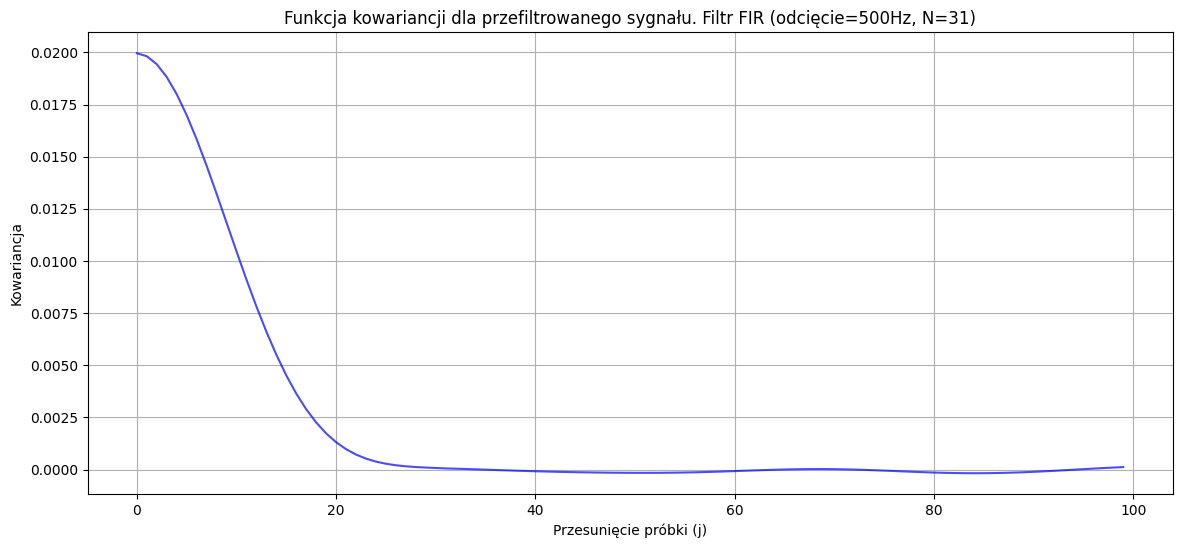

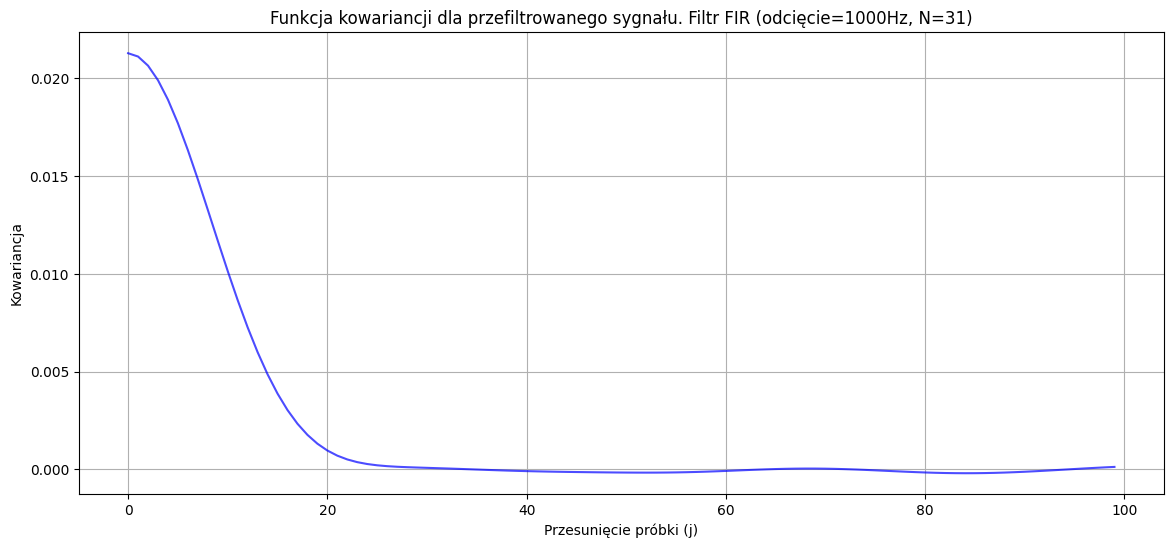

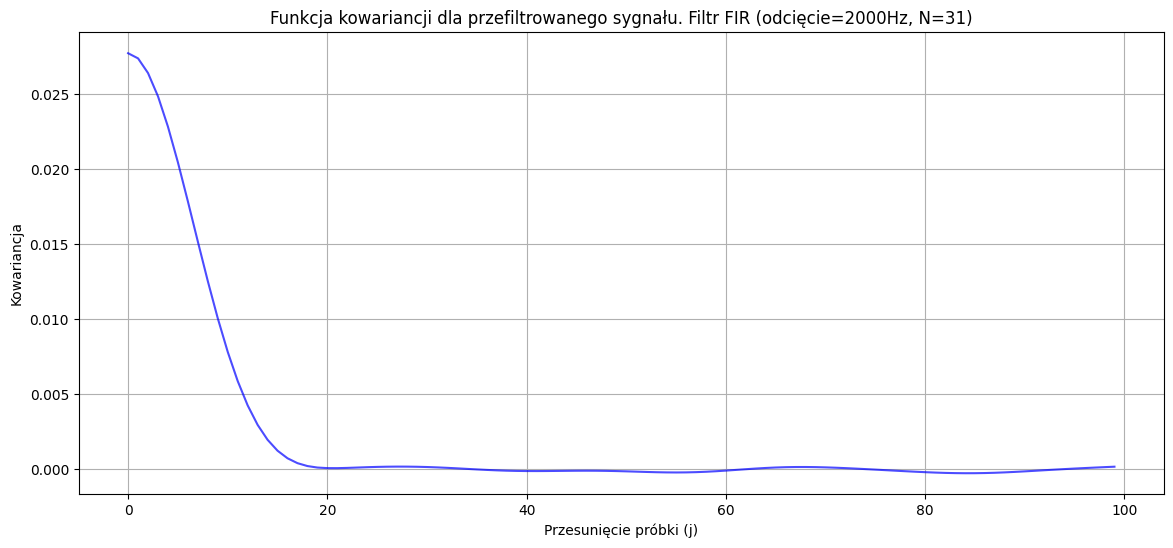

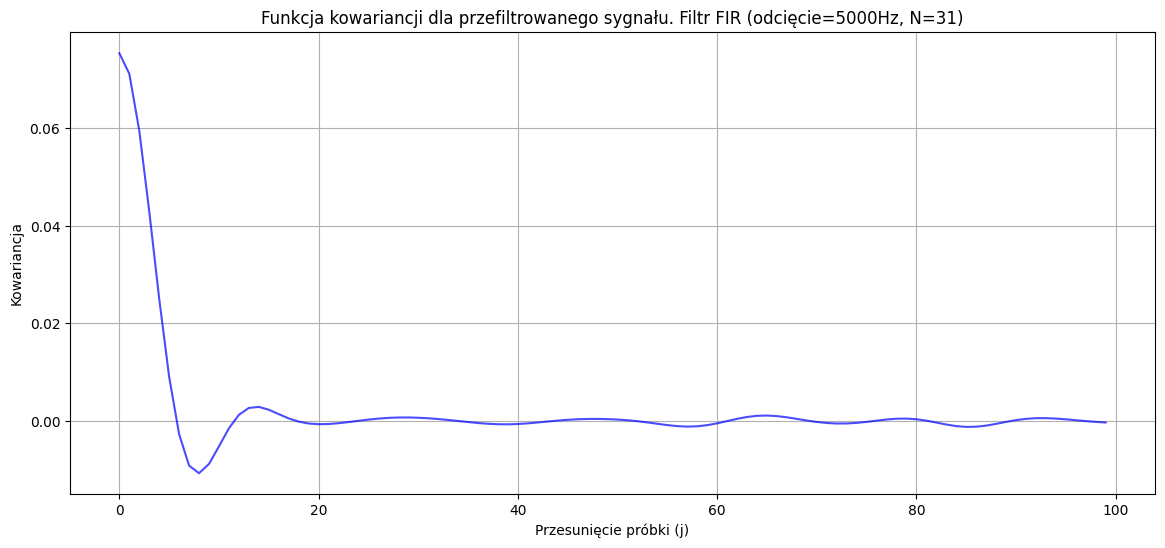

In [47]:
# Rysowanie Funkcji Kowariancji
filtered_kowariance_sums_table = pd.DataFrame(filtered_kowariance_sums)
filtered_kowariance_sums_table = filtered_kowariance_sums_table.transpose()

for i, col in enumerate(filtered_kowariance_sums_table.columns):
    plt.figure(figsize=(14, 6))
    plt.plot(filtered_kowariance_sums_table[col], color="blue", alpha=0.7)
    plt.title(f"Funkcja kowariancji dla przefiltrowanego sygnału. Filtr FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Przesunięcie próbki (j)", )
    plt.ylabel("Kowariancja")
    plt.grid(True)
    plt.show()

In [40]:
filtered_kowariance_sums_table

,0,1,2,3
0,0.019963,0.021290,0.027737,0.075432
1,0.019818,0.021121,0.027393,0.071216
2,0.019434,0.020655,0.026415,0.059554
3,0.018821,0.019910,0.024864,0.043025
4,0.017999,0.018914,0.022837,0.025067
...,...,...,...,...
95,0.000020,0.000022,0.000033,0.000331
96,0.000047,0.000051,0.000066,0.000151
97,0.000073,0.000079,0.000097,-0.000031
98,0.000097,0.000105,0.000127,-0.000197


In [41]:
kowariance_sums_table

,0,1,2,3
0,0.424876,0.430562,0.433687,0.429214
1,0.004899,0.000137,-0.000428,0.000964
2,0.019860,0.002236,0.001930,0.000877
3,-0.012529,-0.004984,0.000472,-0.003150
4,-0.005608,-0.002287,0.004088,0.004100
...,...,...,...,...
95,-0.007248,-0.004733,-0.003059,0.001688
96,0.015594,-0.000005,0.000858,0.000040
97,-0.014877,0.000768,0.001694,0.000413
98,0.015967,0.010880,0.011451,0.001322


In [42]:
df = pd.DataFrame(['1', '2', '3'], columns = ['x'])

rows = 3
columns = 10

df2 = pd.DataFrame([[0 for i in range(columns)]for j in range(rows)],
                    columns = [f'f{k}' for k in range(columns)])

df = df.join(df2)


In [43]:


# Parametry
sigma = 10.0  # Odchylenie standardowe składników Gaussowskich
size = 1000  # Liczba próbek

# Generowanie dwóch niezależnych zmiennych Gaussowskich
X = np.random.normal(0, sigma, size)
Y = np.random.normal(0, sigma, size)

# Obliczenie amplitudy Rayleigha
R = np.sqrt(X**2 + Y**2)

print(R)  # Tablica próbek z rozkładu Rayleigha


[17.50368904 32.06382515 17.44730442 13.41208995 24.41788829 12.19651056
  3.23645039 19.91891736 17.83833463 17.11107077 23.62405215  6.9256318
 17.20148958  8.58076214  9.41243456 25.9294783  10.28286279 26.89988352
  5.40058933  7.22238698 12.86591194  8.95923278 10.11664479 18.61543827
 12.75009297 22.20737737  8.84041509 18.58162598  8.84293301 16.04521813
 17.05283549  7.55362775  6.6299209   4.57213113 20.30201755 25.80468649
  4.30581143 17.96003531 15.21374351 10.96994649 15.10943267 19.14556554
 18.79800815 18.19548672 20.05813561 28.86982228 12.89578459 29.25815686
 16.20831885  8.86329787 10.19776404 18.91209523  6.61348215 17.343341
  8.18546527  9.92121337 20.69674727 17.11253754  4.66486118 10.42310607
 12.33195857  8.11514732 19.91461008 13.56501213 12.90314118  8.80088111
 10.81976405 13.00092271 21.06619905 13.00818598  8.86832914 13.29512483
 17.20699703  4.51462822 12.30338153  3.82998945 30.49103349  8.5752263
  9.62655759  1.75537675  6.18599351  8.59049509  2.815

In [44]:
for i in range (len(X)):
    print(X[i], Y[i], R[i])

12.723743295971207 12.020211588985898 17.503689042763618
25.662805151667815 19.22262508555309 32.06382515284481
-3.7157774821544622 17.047035790885253 17.447304420815524
-7.760209082804558 -10.939072713789527 13.412089950727921
-18.920518963853212 -15.435259331227087 24.41788828878865
-7.459704831515525 9.649231762104787 12.19651055721053
-2.7260068801901403 -1.7445622983763203 3.236450389510096
-19.744493744175163 -2.630253910574795 19.91891736133935
9.075110430729424 15.357361527935788 17.83833463162008
-16.752690017099326 -3.48369344274991 17.11107076754924
23.12527874410186 4.828801426925988 23.62405215480807
-6.521647742147241 2.3307695194188636 6.925631799720965
15.526652513198616 7.403668373702925 17.201489576585683
5.821628165301254 -6.303818240635854 8.580762140159939
-5.73134064087835 -7.466301547166397 9.412434559400834
4.821541560513264 25.477256164299487 25.929478295582673
-10.219318060635121 1.141405032369334 10.282862785836501
-26.88719878900228 -0.8259990455965448 26.89